# Diode Circuit

You can also find this example as a single file in the [GitHub repository](https://github.com/milanofthe/pathsim/blob/master/examples/example_diode.py).This example demonstrates a more complex application of algebraic loop solving: a **diode circuit** with nonlinear characteristics. This showcases PathSim's ability to handle nonlinear implicit equations that arise in real electronic circuits.

## Circuit Description

The circuit consists of:
- A sinusoidal **voltage source**: $V_s(t) = 5\sin(2\pi t)$ V
- A **resistor**: $R = 1000$ Ω
- A **diode** with exponential I-V characteristic

## Diode Model

The diode current follows the Shockley equation:

$$i_D = I_s \left(e^{V_D/V_T} - 1\right)$$

Where:
- $I_s = 10^{-12}$ A (saturation current)
- $V_T = 26$ mV (thermal voltage at room temperature)
- $V_D$ is the diode voltage



## The Algebraic Loop

Applying Kirchhoff's Voltage Law (KVL):

$$V_s = V_D + R \cdot i_D$$

Substituting the diode equation creates a **nonlinear algebraic loop**:

$$V_D = V_s - R \cdot I_s \left(e^{V_D/V_T} - 1\right)$$

PathSim solves this nonlinear equation automatically at each timestep using accelerated fixed-point iteration.

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Apply PathSim docs matplotlib style
plt.style.use('../pathsim_docs.mplstyle')

from pathsim import Simulation, Connection
from pathsim.blocks import Source, Amplifier, Function, Adder, Scope
from pathsim.solvers import RKBS32

## Circuit Parameters

In [8]:
# Circuit parameters
R = 1000.0          # Resistor (Ohms)
I_s = 1e-12         # Diode saturation current (A)
V_T = 0.026         # Thermal voltage at room temperature (V)

# Define diode current function: i = I_s * (exp(v_diode/(V_T)) - 1)
def diode_current(v_diode):
    """Diode current as function of diode voltage"""
    # Clip to prevent numerical overflow
    clipped = np.clip(v_diode/V_T, None, 23)
    return I_s * (np.exp(clipped) - 1)

# Define voltage source function
def voltage_source(t):
    """Sinusoidal voltage source"""
    return 5.0 * np.sin(2 * np.pi * t)

In [10]:
# Blocks that define the system
Src = Source(voltage_source)                    # Voltage source
DiodeFn = Function(diode_current)               # Diode i-v characteristic  
ResAmp = Amplifier(-R)                          # -R (negative resistance)
Add = Adder()                                   # Adder for KVL
Sc1 = Scope(labels=["v_source", "v_diode"])
Sc2 = Scope(labels=["i_diode"])

blocks = [Src, DiodeFn, ResAmp, Add, Sc1, Sc2]

## Connections

The connections implement Kirchhoff's laws:
- The adder computes: $V_{diode} = V_{source} + V_{resistor}$
- The resistor voltage is: $V_{resistor} = -R \cdot i_{diode}$
- The diode current depends on: $V_{diode}$ (creating the loop)

In [13]:
connections = [
    Connection(Src, Add[0], Sc1[0]),            # Source to adder and scope
    Connection(Add, DiodeFn, Sc1[1]),           # Diode voltage to function and scope
    Connection(DiodeFn, ResAmp, Sc2),           # Diode current to resistor and scope
    Connection(ResAmp, Add[1]),                 # Voltage drop back to adder (loop!)
]

## Simulation

We use a tight convergence tolerance (`tolerance_fpi=1e-12`) to ensure accurate solution of the nonlinear algebraic equation.

In [16]:
# Simulation instance
Sim = Simulation(
    blocks, 
    connections, 
    dt=0.001,
    tolerance_fpi=1e-12
)

# Run the simulation for 2 seconds
Sim.run(duration=2.0)

2025-10-10 13:56:10,134 - INFO - LOGGING (log: True)
2025-10-10 13:56:10,135 - INFO - BLOCK (type: Source, dynamic: False, events: 0)
2025-10-10 13:56:10,136 - INFO - BLOCK (type: Function, dynamic: False, events: 0)
2025-10-10 13:56:10,136 - INFO - BLOCK (type: Amplifier, dynamic: False, events: 0)
2025-10-10 13:56:10,136 - INFO - BLOCK (type: Adder, dynamic: False, events: 0)
2025-10-10 13:56:10,136 - INFO - BLOCK (type: Scope, dynamic: False, events: 0)
2025-10-10 13:56:10,137 - INFO - BLOCK (type: Scope, dynamic: False, events: 0)
2025-10-10 13:56:10,137 - INFO - GRAPH (size: 6, alg. depth: 1, loop depth: 3, runtime: 0.106ms)
2025-10-10 13:56:10,138 - INFO - STARTING -> TRANSIENT (Duration: 2.00s)
2025-10-10 13:56:10,138 - INFO - TRANSIENT:   0% | elapsed: 00:00:00 (eta: --:--:--) | 0 steps (N/A steps/s)
2025-10-10 13:56:10,340 - INFO - TRANSIENT:  20% | elapsed: 00:00:00 (eta: 00:00:00) | 400 steps (1978.9 steps/s)
2025-10-10 13:56:10,383 - INFO - TRANSIENT:  40% | elapsed: 00:00:

{'total_steps': 2001,
 'successful_steps': 2001,
 'runtime_ms': 477.7083000008133}

## Results: Voltage Waveforms

The plots show:
- **v_source** (blue): Input sinusoidal voltage
- **v_diode** (orange): Voltage across the diode

Notice how the diode voltage is:
- **Clamped near ~0.7V** during forward bias (positive half-cycle)
- **Follows the source** during reverse bias (negative half-cycle, diode is off)

This is the classic diode rectifier behavior!

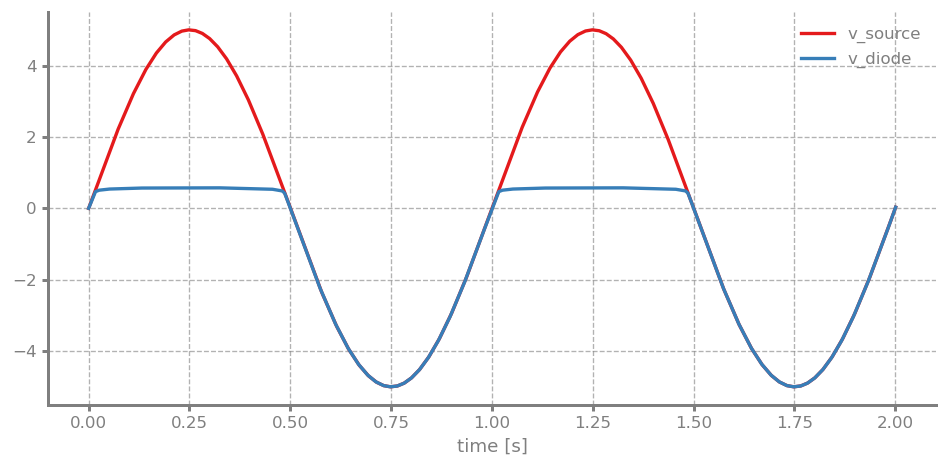

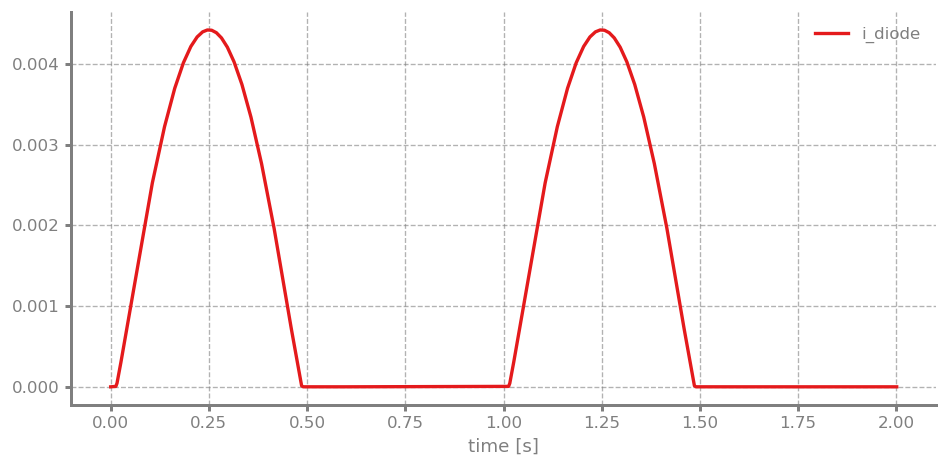

In [19]:
Sim.plot()
plt.show()

## Diode Current

Let's examine the diode current to see the rectification more clearly.

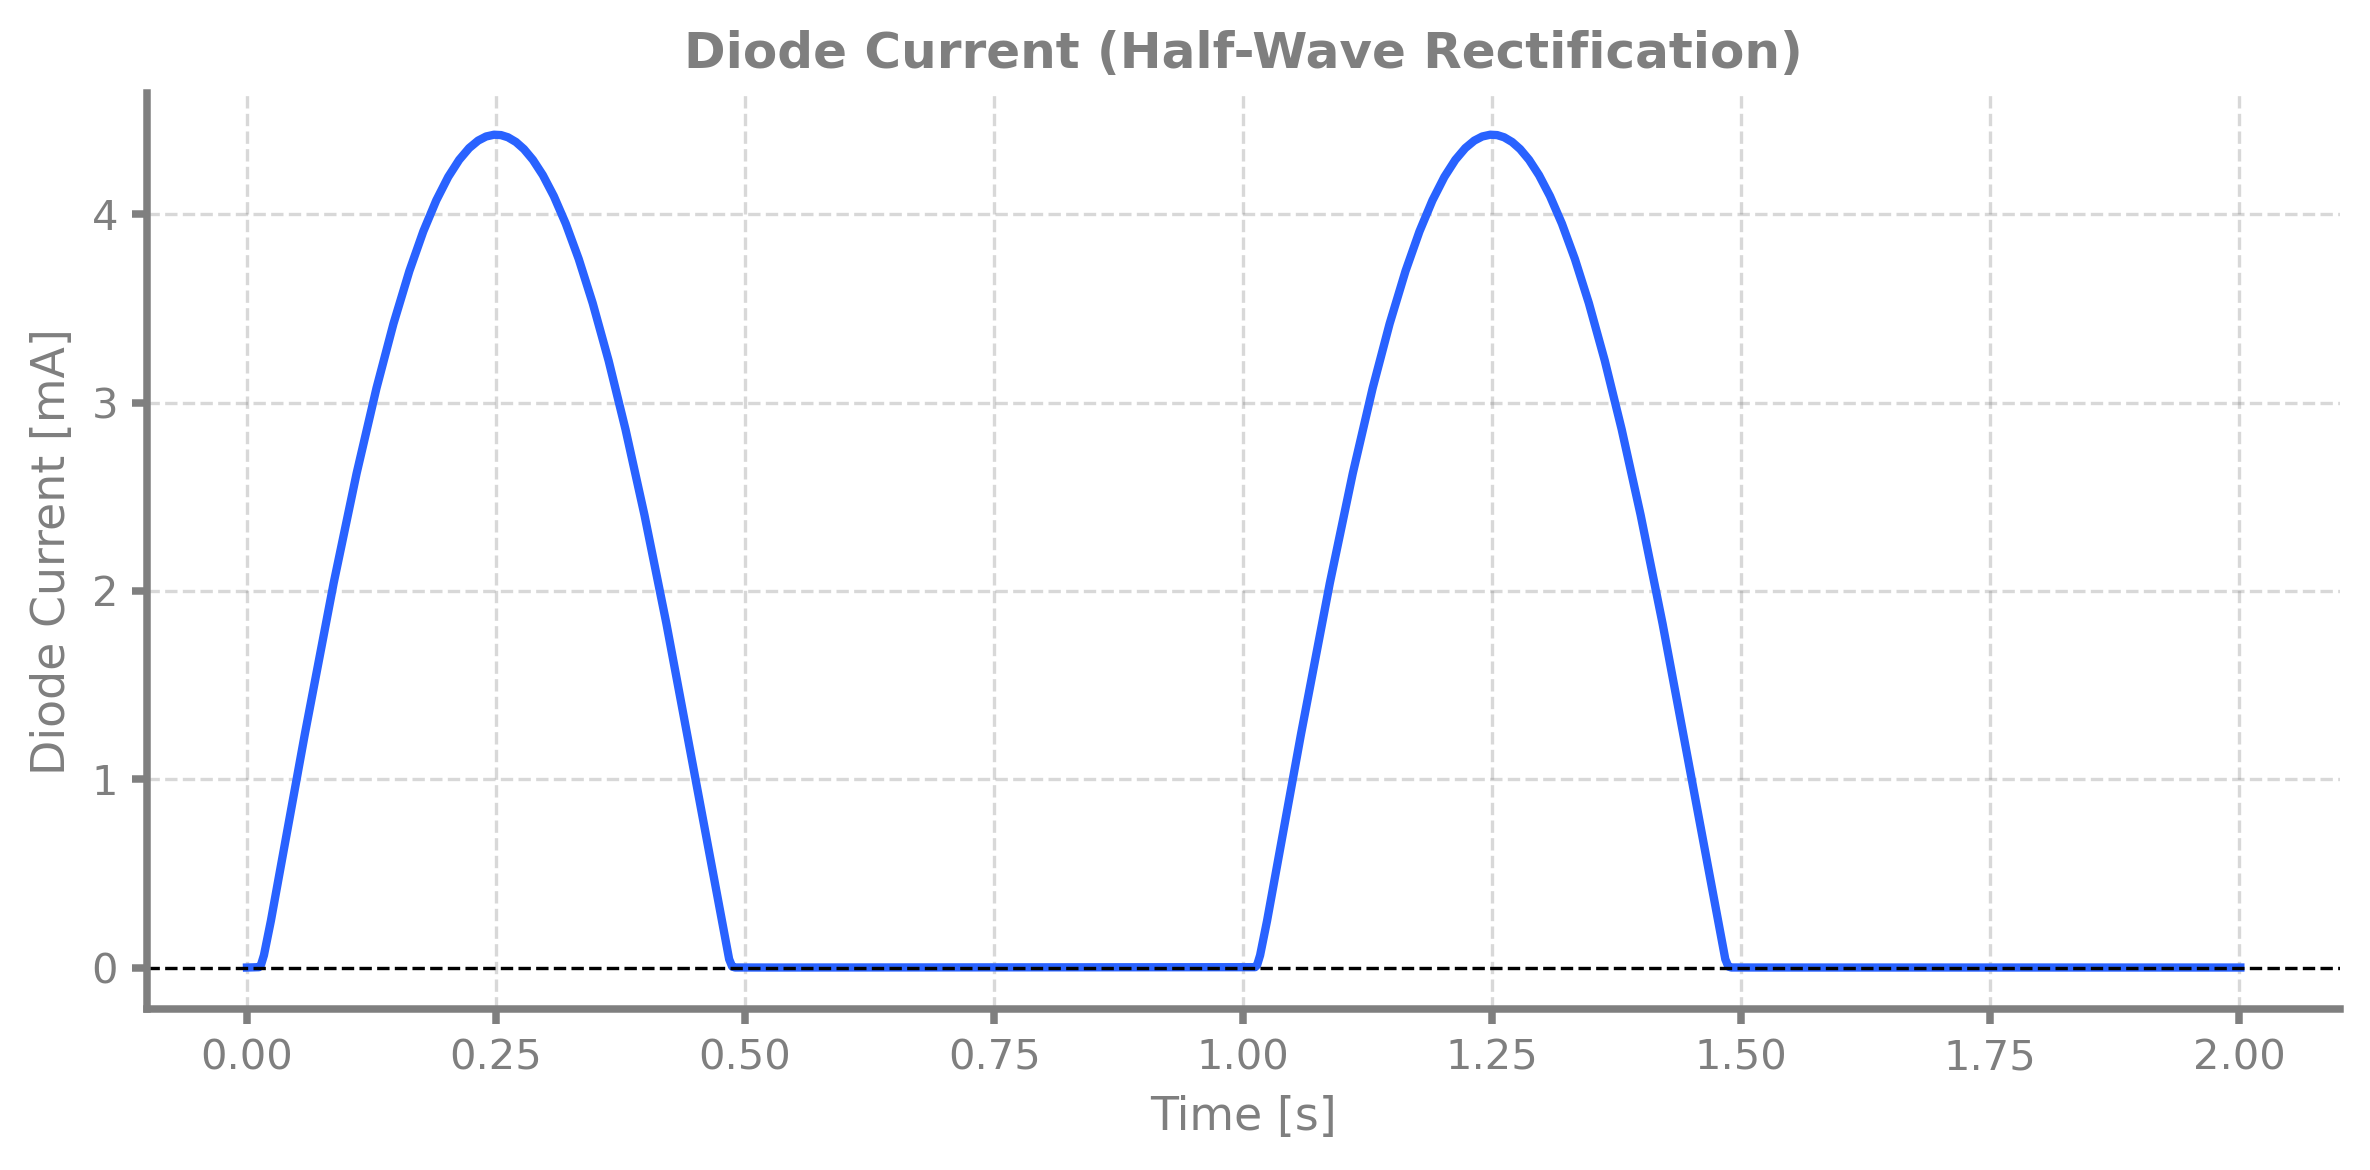

In [24]:
# Get results
time, [i_diode] = Sc2.read()

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(time, i_diode * 1000, linewidth=2)  # Convert to mA
ax.set_xlabel('Time [s]')
ax.set_ylabel('Diode Current [mA]')
ax.set_title('Diode Current (Half-Wave Rectification)')
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='k', linestyle='--', linewidth=0.8)
plt.tight_layout()
plt.show()

## Diode I-V Characteristic

We can also visualize the diode's I-V characteristic by plotting current vs. voltage.

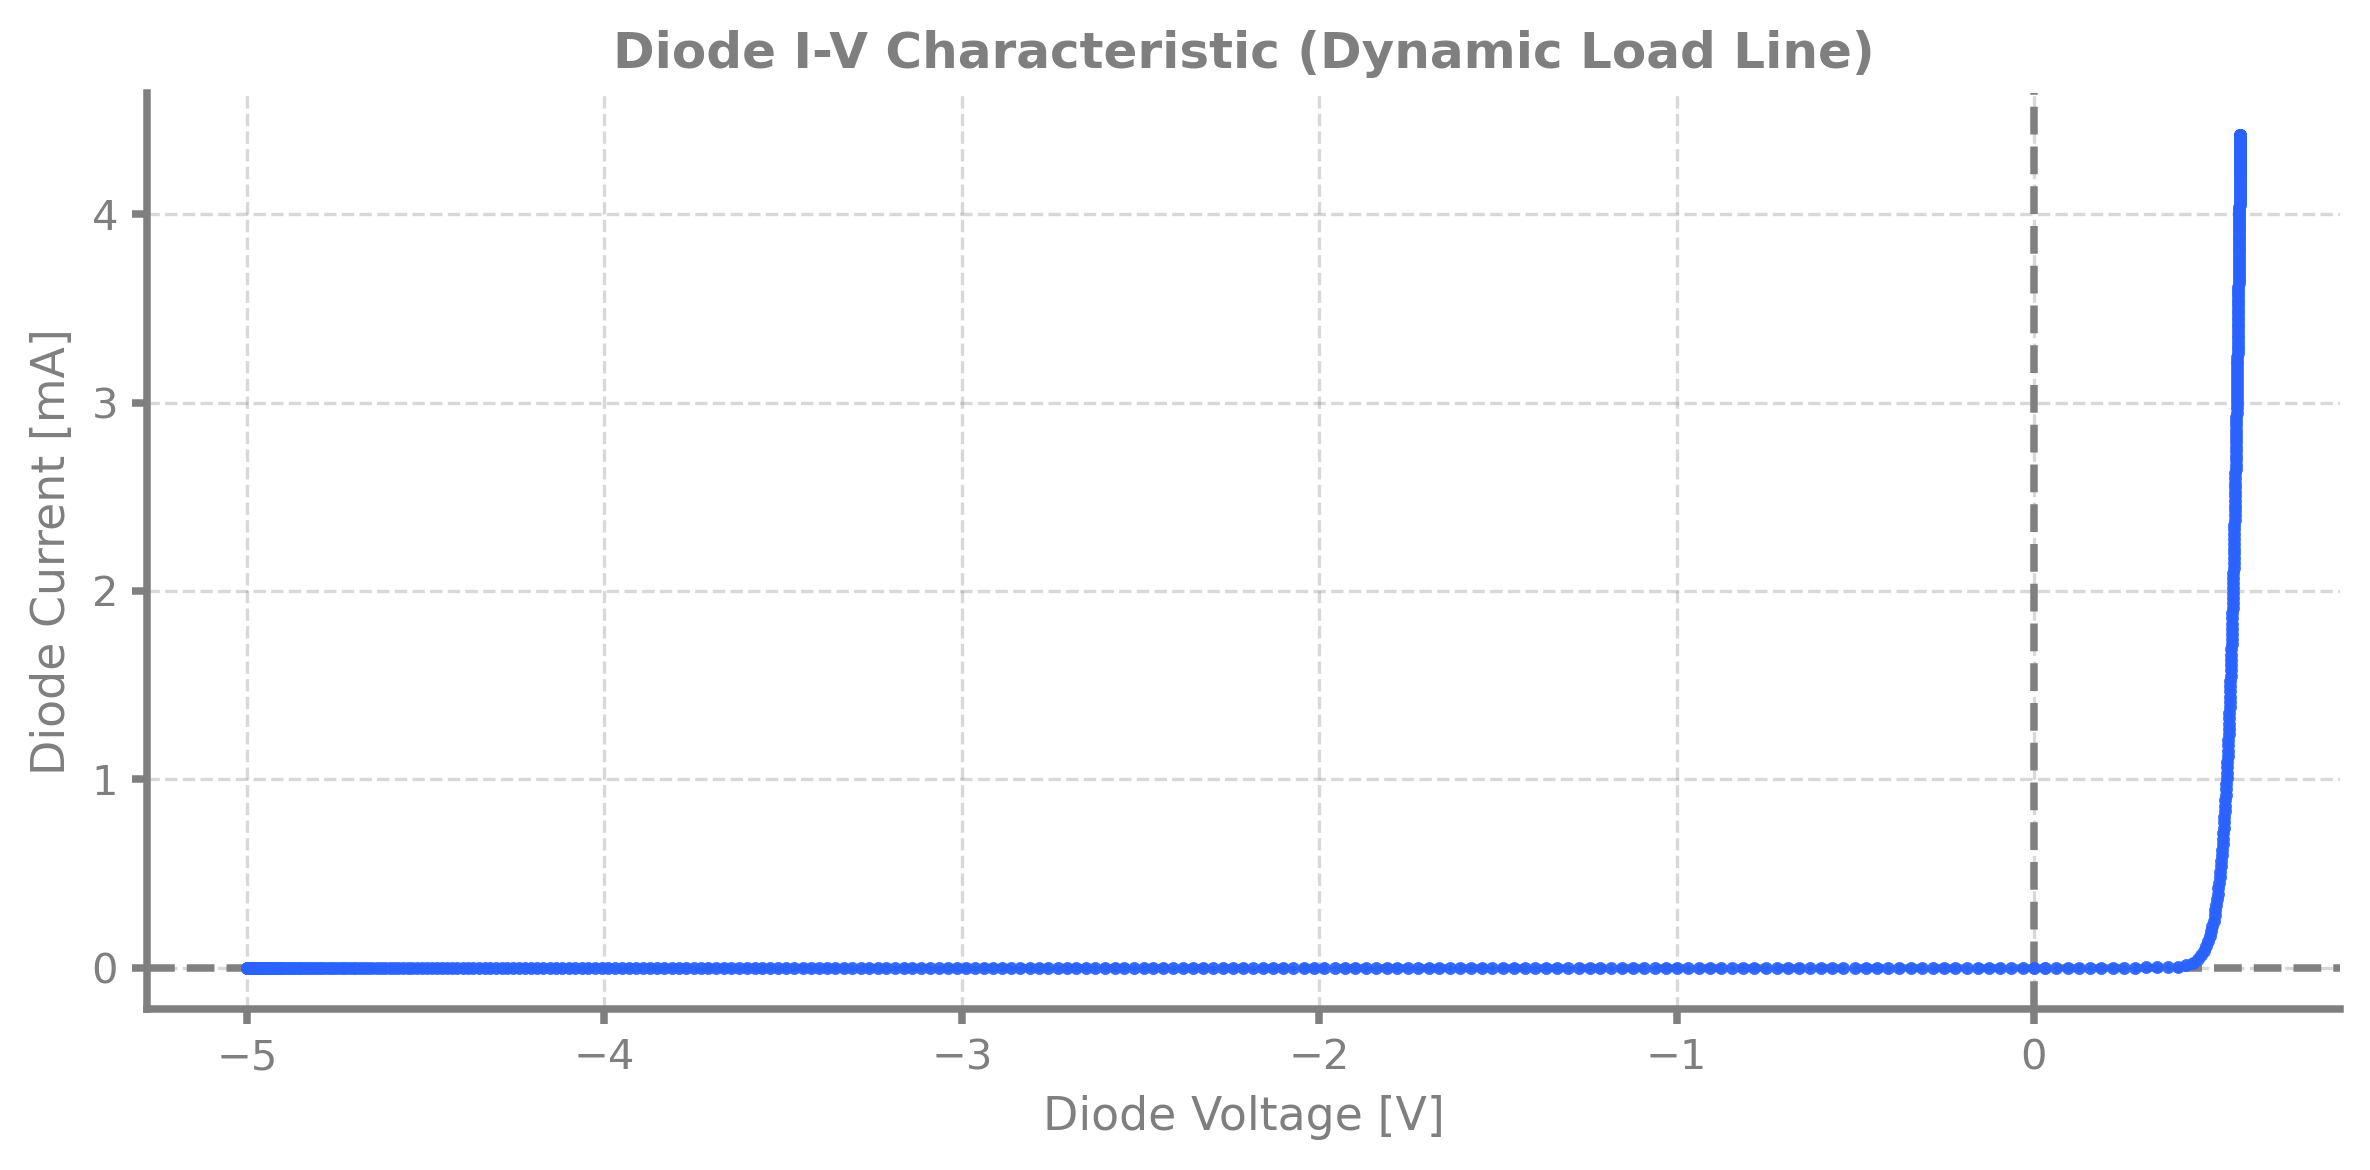

In [36]:
# Get diode voltage
_, [v_source, v_diode] = Sc1.read()

# Plot I-V characteristic
fig, ax = plt.subplots(figsize=(8, 4))

ax.axhline(y=0, color='grey', linestyle='--', linewidth=1.8)
ax.axvline(x=0, color='grey', linestyle='--', linewidth=1.8)

ax.plot(v_diode, i_diode * 1000, '.', markersize=3, alpha=0.5)

ax.set_xlabel('Diode Voltage [V]')
ax.set_ylabel('Diode Current [mA]')
ax.set_title('Diode I-V Characteristic (Dynamic Load Line)')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()